# Data Preprocessing and Feature Engineering

Load and Basic checks

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv("clean_dataset.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

print(df.shape)
df.head()

(2288, 9)


,date,usdjpy,gold,spx,dgs2,dgs5,dgs10,unrate,cpi
0,2017-01-03,117.495003,1160.400024,2257.830078,1.22,1.94,2.45,4.7,243.618
1,2017-01-04,117.658997,1163.800049,2270.750000,1.24,1.94,2.46,4.7,243.618
2,2017-01-05,117.112999,1179.699951,2269.000000,1.17,1.86,2.37,4.7,243.618
3,2017-01-06,115.264999,1171.900024,2276.979980,1.22,1.92,2.42,4.7,243.618
4,2017-01-09,117.150002,1183.500000,2268.899902,1.21,1.89,2.38,4.7,243.618


In [2]:
#  FIX macro alignment using merge_asof 

cpi_raw = pd.read_csv("downloadfred/CPIAUCSL.csv")
unrate_raw = pd.read_csv("downloadfred/UNRATE.csv")

# rename
cpi_raw = cpi_raw.rename(columns={
    "observation_date": "date",
    "CPIAUCSL": "cpi_raw"
})
unrate_raw = unrate_raw.rename(columns={
    "observation_date": "date",
    "UNRATE": "unrate_raw"
})

# datetime
cpi_raw["date"] = pd.to_datetime(cpi_raw["date"])
unrate_raw["date"] = pd.to_datetime(unrate_raw["date"])

# numeric + forward fill
cpi_raw["cpi_raw"] = pd.to_numeric(cpi_raw["cpi_raw"], errors="coerce").ffill()
unrate_raw["unrate_raw"] = pd.to_numeric(unrate_raw["unrate_raw"], errors="coerce").ffill()

# sort
cpi_raw = cpi_raw.sort_values("date")
unrate_raw = unrate_raw.sort_values("date")

# merge_asof
df = pd.merge_asof(df.sort_values("date"), cpi_raw, on="date", direction="backward")
df = pd.merge_asof(df.sort_values("date"), unrate_raw, on="date", direction="backward")

# replace columns
df["cpi"] = df["cpi_raw"]
df["unrate"] = df["unrate_raw"]
df = df.drop(columns=["cpi_raw","unrate_raw"])

print("Macro missing after fix:")
print(df[["cpi","unrate"]].isna().sum())

Macro missing after fix:
cpi       0
unrate    0
dtype: int64


In [3]:
df.isna().sum()

date      0
usdjpy    0
gold      0
spx       0
dgs2      0
dgs5      0
dgs10     0
unrate    0
cpi       0
dtype: int64

In [4]:
# the macro missing values
missing_macro = df[df[["unrate","cpi"]].isna().any(axis=1)][["date","unrate","cpi"]]
print("Missing macro rows:", len(missing_macro))
missing_macro.head(), missing_macro.tail()

Missing macro rows: 0


(Empty DataFrame
 Columns: [date, unrate, cpi]
 Index: [],
 Empty DataFrame
 Columns: [date, unrate, cpi]
 Index: [])

In [5]:
# sanity check: missing macro date range
print(missing_macro["date"].min(), "to", missing_macro["date"].max())

NaT to NaT


In [6]:
# macro info to daily trading days (use latest available release)
'''
df["unrate"] = df["unrate"].ffill()
df["cpi"] = df["cpi"].ffill()

print("After ffill:")
df[["unrate","cpi"]].isna().sum()
'''

'\ndf["unrate"] = df["unrate"].ffill()\ndf["cpi"] = df["cpi"].ffill()\n\nprint("After ffill:")\ndf[["unrate","cpi"]].isna().sum()\n'

In [7]:
#log returns
df["spx_ret"]  = np.log(df["spx"]).diff()
df["gold_ret"] = np.log(df["gold"]).diff()
df["fx_ret"]   = np.log(df["usdjpy"]).diff()

df[["date","spx_ret","gold_ret","fx_ret"]].head(10)

,date,spx_ret,gold_ret,fx_ret
0,2017-01-03,NaN,NaN,NaN
1,2017-01-04,0.005706,0.002926,0.001395
2,2017-01-05,-0.000771,0.013570,-0.004651
3,2017-01-06,0.003511,-0.006634,-0.015905
4,2017-01-09,-0.003555,0.009850,0.016221
5,2017-01-10,0.000000,0.000591,-0.009994
6,2017-01-11,0.002826,0.009581,-0.000975
7,2017-01-12,-0.002147,0.002756,-0.006702
8,2017-01-13,0.001848,-0.003007,-0.003778
9,2017-01-17,-0.002972,0.013875,-0.004475


In [8]:
# Rolling volatility
TRADING_DAYS = 252
df["spx_vol_21"]  = df["spx_ret"].rolling(21).std() * np.sqrt(TRADING_DAYS)
df["gold_vol_21"] = df["gold_ret"].rolling(21).std() * np.sqrt(TRADING_DAYS)
df["fx_vol_21"]   = df["fx_ret"].rolling(21).std() * np.sqrt(TRADING_DAYS)

df[["date","spx_vol_21"]].tail()

,date,spx_vol_21
2283,2026-02-10,0.132413
2284,2026-02-11,0.132263
2285,2026-02-12,0.142776
2286,2026-02-13,0.141917
2287,2026-02-17,0.141578


In [9]:
#Yield spread + inversion regime
df["yc_10_2"] = df["dgs10"] - df["dgs2"]
df["yc_10_5"] = df["dgs10"] - df["dgs5"]
df["yc_inversion"] = (df["yc_10_2"] < 0).astype(int)

df[["date","yc_10_2","yc_inversion"]].tail()

,date,yc_10_2,yc_inversion
2283,2026-02-10,0.71,0
2284,2026-02-11,0.66,0
2285,2026-02-12,0.62,0
2286,2026-02-13,0.64,0
2287,2026-02-17,0.62,0


In [10]:
# Macro change（CPI pct change + UNRATE diff）
df["infl_chg"]  = df["cpi"].pct_change()
df["unemp_chg"] = df["unrate"].diff()

df[["date","infl_chg","unemp_chg"]].tail()

,date,infl_chg,unemp_chg
2283,2026-02-10,0.0,0.0
2284,2026-02-11,0.0,0.0
2285,2026-02-12,0.0,0.0
2286,2026-02-13,0.0,0.0
2287,2026-02-17,0.0,0.0


In [11]:
# Macro release "event" indicators (monthly jump days)
df["infl_event"]  = (df["infl_chg"].fillna(0) != 0).astype(int)
df["unemp_event"] = (df["unemp_chg"].fillna(0) != 0).astype(int)

# event window (market may react within a few days after release)
df["infl_event_5d"]  = df["infl_event"].rolling(5).max()
df["unemp_event_5d"] = df["unemp_event"].rolling(5).max()

In [12]:
#Momentum + trend
df["spx_mom_21"]  = df["spx"].pct_change(21)
df["gold_mom_21"] = df["gold"].pct_change(21)
df["fx_mom_21"]   = df["usdjpy"].pct_change(21)

df["spx_ma_50"] = df["spx"].rolling(50).mean()
df["spx_ma_ratio"] = df["spx"] / df["spx_ma_50"]

df[["date","spx_mom_21","spx_ma_ratio"]].tail()

,date,spx_mom_21,spx_ma_ratio
2283,2026-02-10,-0.003513,1.007191
2284,2026-02-11,-0.005131,1.006872
2285,2026-02-12,-0.018809,0.991045
2286,2026-02-13,-0.013055,0.991520
2287,2026-02-17,-0.014580,0.992562


In [13]:
# Interaction + volatility regime
df["spx_vol_infl"]  = df["spx_vol_21"] * df["infl_chg"]
df["spx_vol_unemp"] = df["spx_vol_21"] * df["unemp_chg"]

df["high_vol"] = (df["spx_vol_21"] > df["spx_vol_21"].quantile(0.8)).astype(int)

df[["date","spx_vol_infl","high_vol"]].tail()

,date,spx_vol_infl,high_vol
2283,2026-02-10,0.0,0
2284,2026-02-11,0.0,0
2285,2026-02-12,0.0,0
2286,2026-02-13,0.0,0
2287,2026-02-17,0.0,0


In [14]:
df["spx_vol_infl_event"]  = df["spx_vol_21"] * df["infl_event_5d"]
df["spx_vol_unemp_event"] = df["spx_vol_21"] * df["unemp_event_5d"]

In [15]:
#check
df[[
    "infl_event_5d",
    "spx_vol_infl_event"
]].sum()

infl_event_5d         535.000000
spx_vol_infl_event     82.465997
dtype: float64

In [16]:
# define feature column + dropna
feature_cols = [
    "spx_ret","gold_ret","fx_ret",
    "spx_vol_21","gold_vol_21","fx_vol_21",
    "yc_10_2","yc_10_5","yc_inversion",
    "infl_chg","unemp_chg",
    "infl_event_5d","unemp_event_5d",
    "spx_vol_infl","spx_vol_unemp",
    "spx_vol_infl_event","spx_vol_unemp_event",
    "spx_mom_21","gold_mom_21","fx_mom_21",
    "spx_ma_ratio",
    "high_vol"
]

df_model = df.dropna(subset=feature_cols).copy()
print("Model-ready rows:", df_model.shape)
df_model[["date"] + feature_cols].head()

Model-ready rows: (2239, 34)


,date,spx_ret,gold_ret,fx_ret,spx_vol_21,gold_vol_21,fx_vol_21,yc_10_2,yc_10_5,yc_inversion,...,unemp_event_5d,spx_vol_infl,spx_vol_unemp,spx_vol_infl_event,spx_vol_unemp_event,spx_mom_21,gold_mom_21,fx_mom_21,spx_ma_ratio,high_vol
49,2017-03-15,0.008340,-0.001499,-0.002230,0.071021,0.093510,0.069263,1.18,0.49,0,...,0.0,0.0,0.0,0.0,0.0,0.024486,-0.019846,0.006540,1.029017,0
50,2017-03-16,-0.001628,0.021760,-0.011023,0.070853,0.122255,0.079417,1.18,0.48,0,...,0.0,0.0,0.0,0.0,0.0,0.018737,0.002124,-0.002665,1.026249,0
51,2017-03-17,-0.001315,0.002687,-0.000547,0.069613,0.120540,0.076994,1.17,0.47,0,...,0.0,0.0,0.0,0.0,0.0,0.012344,-0.001543,-0.008408,1.023951,0
52,2017-03-20,-0.002012,0.003085,-0.005893,0.070026,0.118604,0.079230,1.17,0.47,0,...,0.0,0.0,0.0,0.0,0.0,0.011183,-0.005161,-0.012602,1.020975,0
53,2017-03-21,-0.012486,0.010082,-0.000897,0.083073,0.123646,0.075658,1.16,0.47,0,...,0.0,0.0,0.0,0.0,0.0,-0.003037,0.006868,-0.006460,1.007725,0


In [17]:
# Standardize numerical features 
binary_cols = ["yc_inversion", "high_vol", "infl_event_5d", "unemp_event_5d"]
num_cols = [c for c in feature_cols if c not in binary_cols]

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df_model[num_cols])

df_scaled = pd.DataFrame(X_num_scaled, columns=num_cols, index=df_model.index)
df_scaled[binary_cols] = df_model[binary_cols].values
df_scaled["date"] = df_model["date"].values

df_scaled = df_scaled[["date"] + num_cols + binary_cols]

print("Scaled dataset shape:", df_scaled.shape)
df_scaled.head()

Scaled dataset shape: (2239, 23)


,date,spx_ret,gold_ret,fx_ret,spx_vol_21,gold_vol_21,fx_vol_21,yc_10_2,yc_10_5,infl_chg,...,spx_vol_infl_event,spx_vol_unemp_event,spx_mom_21,gold_mom_21,fx_mom_21,spx_ma_ratio,yc_inversion,high_vol,infl_event_5d,unemp_event_5d
49,2017-03-15,0.665776,-0.207381,-0.425367,-0.774245,-0.819329,-0.381907,1.584156,1.132915,-0.155247,...,-0.433066,-0.354302,0.285139,-0.827437,0.131120,0.434268,0.0,0.0,0.0,0.0
50,2017-03-16,-0.177966,2.062556,-2.010339,-0.775799,-0.371591,-0.069450,1.584156,1.090767,-0.155247,...,-0.433066,-0.354302,0.161429,-0.289434,-0.236099,0.362647,0.0,0.0,0.0,0.0
51,2017-03-17,-0.151484,0.201137,-0.121945,-0.787304,-0.398296,-0.144028,1.566168,1.048618,-0.155247,...,-0.433066,-0.354302,0.023863,-0.379224,-0.465208,0.303197,0.0,0.0,0.0,0.0
52,2017-03-20,-0.210460,0.239990,-1.085647,-0.783472,-0.428455,-0.075213,1.566168,1.048618,-0.155247,...,-0.433066,-0.354302,-0.001119,-0.467839,-0.632522,0.226178,0.0,0.0,0.0,0.0
53,2017-03-21,-1.097013,0.922853,-0.185020,-0.662454,-0.349923,-0.185113,1.548179,1.048618,-0.155247,...,-0.433066,-0.354302,-0.307119,-0.173272,-0.387525,-0.116658,0.0,0.0,0.0,0.0


In [18]:
df_scaled.to_csv("scaled_features.csv", index=False)

print("Saved scaled_features.csv")

Saved scaled_features.csv


In [19]:
combined_cols = ["date","usdjpy","gold","spx","dgs2","dgs5","dgs10","unrate","cpi"] + feature_cols
combined = df_model[combined_cols].copy()
combined.to_csv("combined_dataset.csv", index=False)

print("Saved combined_dataset.csv:", combined.shape)

Saved combined_dataset.csv: (2239, 31)


In [20]:
processed = df_model[["date"] + feature_cols].copy()
processed.to_csv("processed_dataset.csv", index=False)

print("Saved processed_dataset.csv:", processed.shape)

Saved processed_dataset.csv: (2239, 23)


If we want to fo Machine Learning in the future, feature scaling will be performed after time-based data splitting to avoid information leakage from future observations.

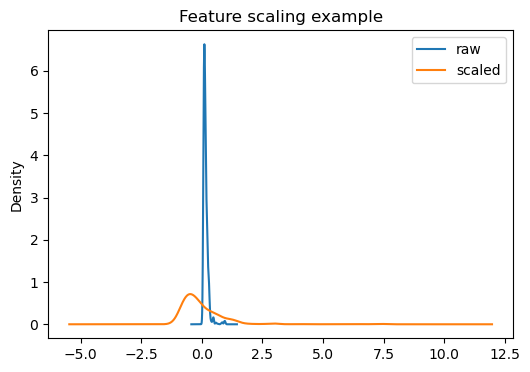

In [26]:
plt.figure(figsize=(6,4))

df_model["spx_vol_21"].plot(kind="kde", label="raw")
df_scaled["spx_vol_21"].plot(kind="kde", label="scaled")

plt.legend()
plt.title("Feature scaling example")
plt.show()